# Exercices
With each exercice will teach you one aspect of deep learning. The process of machine learning can be decompose in 7 steps :

* Data preparation
* Model definition
* Model training
* Model evaluation
* Hyperparameter tuning
* Prediction

## 3 - Model training

- 3.1 Metrics : evaluate model
- 3.2 Loss function (mean square error, cross entropy)
- 3.3 Optimizer function (stochastic gradient descent)
- 3.4 Batch size, epoch number

### Load dataset

In [1]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

data_path = './data'

#trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trans = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

# if not exist, download mnist dataset
train_set = dset.MNIST(root=data_path, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=data_path, train=False, transform=trans, download=True)

batch = 4

data_train_loader = DataLoader(train_set, batch_size=batch, shuffle=True, num_workers=8)
data_test_loader = DataLoader(test_set, batch_size=batch, num_workers=8)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

### Define the network architecture

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


leNet = Net()
print(leNet)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Define loss criterion and optimizer

In [3]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(leNet.parameters(), lr=0.01)

### Training loop

In [4]:
for epoch in range(3):  # loop over the dataset multiple times
    leNet.train()
    
    running_loss = 0.0
    for i, (images, labels) in enumerate(data_train_loader):
        optimizer.zero_grad()

        output = leNet(images)
        
        # align vectors labels <=> outputs
        label_vect = torch.zeros(4, 10, dtype=torch.float)
        for j in range(0, len(labels)):
            label_vect[j, labels[j]] = 1.0 
        loss = criterion(output, label_vect)
    
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
                  
    print('[{:d}] loss: {:.5f}'.format(epoch + 1, running_loss / (batch*len(data_train_loader))))
          
print('Finished Training')

[1] loss: 0.01518
[2] loss: 0.00453
[3] loss: 0.00311
Finished Training


### Test the model

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(images, labels):
    npimg = images.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Ground Truth: {}".format(labels))

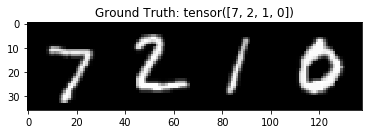

In [6]:
import torchvision

dataiter = iter(data_test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images), labels)


In [7]:
outputs = leNet(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:      7     2     1     0


### Saving leNet

In [8]:
torch.save({
            'epoch': 1,
            'model_state_dict': leNet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'checkpoint-MKTD-pytorch-3.last')